# Clusterização

## Aplicações
- Segmentação dos clientes
- Redução de dimensionalidade -> novas variáveis: afinidade aos k clusters
- Detecção de anomalia
- Aprendizado semi-supervisionado (quando há poucos rótulos)
- Mecanismos de pesquisa por similaridade
- Segmentação de imagem (clusterizar os pixels de acordo com a cor e atribuir uma única cor -> identifica bordas)

## Algoritmo K-Means
- Inicializa aleatoriamente k centróides -> rotula os dados -> ajusta os centróides -> repete

### Dataset

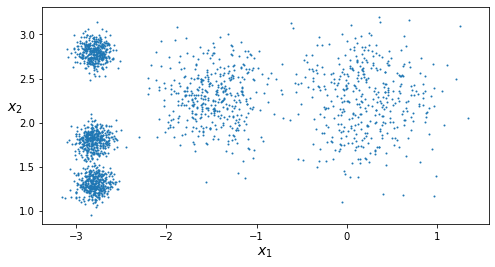

In [1]:
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt

blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)
    
plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.show()

### Fit & Predict

In [18]:
from sklearn.cluster import KMeans
k = 5
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X)
print(y_pred[:10])
print(kmeans.labels_[:10]) # cópia dos labels dos dados de treinamento
print(kmeans.cluster_centers_)

[3 2 2 3 1 2 3 3 0 4]
[3 2 2 3 1 2 3 3 0 4]
[[ 1.83208484  0.02324842]
 [-0.72098091  0.57642509]
 [ 0.98294772 -0.28893443]
 [ 0.16612587  0.01245744]
 [ 0.43342436  0.80438106]]


### Fronteiras de decisão

In [19]:
# Nota: o algoritmo K-Means se comporta melhor quando não há muita disparidade nas variâncias das distribuições.
kmeans.cluster_centers_

def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

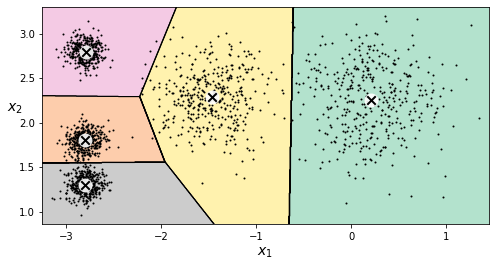

In [5]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()

### Soft clustering
- Distância para os centróides: pode ser usado para redução da dimensionalidade

In [6]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
print(kmeans.transform(X_new))
print(kmeans.predict(X_new))

[[0.32995317 2.81093633 2.9042344  1.49439034 2.88633901]
 [2.80290755 5.80730058 5.84739223 4.4759332  5.84236351]
 [3.29399768 1.21475352 0.29040966 1.69136631 1.71086031]
 [3.21806371 0.72581411 0.36159148 1.54808703 1.21567622]]
[0 0 2 2]


### Métodos de inicialização do centróide
- Pode-se inicializar manualmente através do argumento <span style='font-family: Monospace;'>init</span>
- Entretanto, há um algoritmo adequado para isso que a biblioteca scikit-learn usa por padrão:
<ol style='font-weight: bold;'>
    <li><p style='font-weight: normal;'>Escolha o primeiro centro a partir de uma instância aleatória dos dados</p></li>
    <li><p style='font-weight: normal;'>Para todo o conjunto de dados, calcule a distância <strong>D(x)</strong> entre os dados e seu respectivo centróide mais próximo</p></li>
    <li><p style='font-weight: normal;'>Escolha um novo centróide a partir do conjunto de dados seguindo uma distribuição de probabilidade ponderada por <strong>D(x)<sup>2</sup></strong></p></li>
    <li><p style='font-weight: normal;'>Repita os passos <strong>2</strong> e <strong>3</strong> até que k centróides tenham sido escolhidos</p></li>

In [7]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1) # n_init é o número de iterações
kmeans.fit(X)
kmeans.inertia_ # somatória das distâncias ao quadrado aos centróides

211.62337889822362

### K-Means Acelerado e mini-batch K-Means
- O algoritmo padrão do K-Means é o proposto por Charles Elkan, 2013. Nele o algoritmo foi acelerado, explorando a desigualdade triangular, para evitar cálculos desnecessários de distâncias.
- Já o mini-batch K-Means é interessante quando o número de clusters é elevado, pois ele é bem mais rápido que o algoritmo padrão conforme o número de clusters aumenta.

In [8]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=5)
minibatch_kmeans.fit(X)

MiniBatchKMeans(n_clusters=5)

### Encontrando o número ótimo de clusters
- A inércia sempre diminui conforme o número de clusters aumenta, então precisamos de outra métrica
- Uma métrica melhor é o coeficiente de silhouette: varia entre -1 e 1: compara, para todas as instâncias, a distância média entre as amostras do próprio cluster (a) e as amostras do cluster vizinho mais próximo (b). A fórmula é (b-a)/max(a,b). 

In [9]:
from sklearn.metrics import silhouette_score
silhouette_score(X, kmeans.labels_)

0.655517642572828

In [10]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

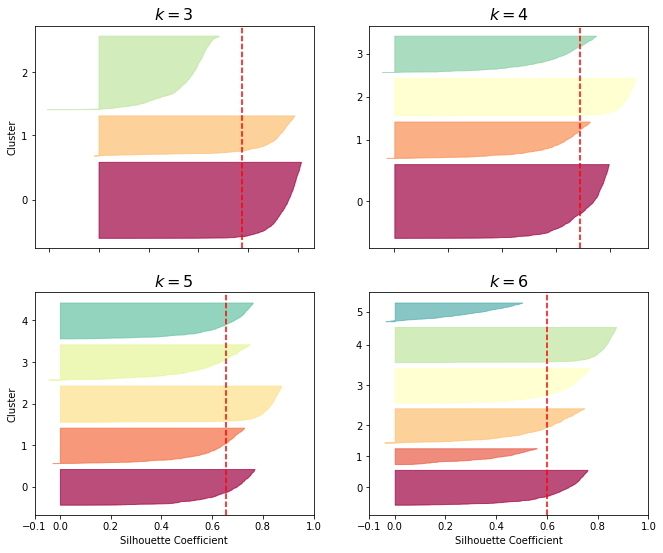

In [11]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib as mpl

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

#### Comentários
- Geralmente o cluster é ruim quando suas amostras estão abaixo do nível médio, o que é observado em k=3 e k=6
- Com k=5 os clusters possuem o mesmo tamanho, apesar do coeficiente de silhouette ser ligeiramente menor do que para k=4.

### Limites do K-Means
- É necessário executar múltiplas vezes e determinar o número de clusters a priori
- K-Means não se comporta bem se os dados não foram escalados previamente e se não forem esféricos

## Exemplos de Aplicações

### Pré-processamento

In [9]:
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits)

In [11]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)
log_reg.score(X_test, y_test)

0.9466666666666667

In [12]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('kmeans', KMeans(n_clusters=50)), # cada dígito pode ser escrito de diferentes formas, por isso, melhor 50 que 10
    ('log_reg', LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42))
])
pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

0.9777777777777777

In [16]:
from sklearn.model_selection import GridSearchCV

param_grid = dict(kmeans__n_clusters=range(2,100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 98 candidates, totalling 294 fits
[CV] kmeans__n_clusters=2 ............................................
[CV] ............................. kmeans__n_clusters=2, total=   0.2s
[CV] kmeans__n_clusters=2 ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ............................. kmeans__n_clusters=2, total=   0.2s
[CV] kmeans__n_clusters=2 ............................................
[CV] ............................. kmeans__n_clusters=2, total=   0.1s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   0.2s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   0.2s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   0.2s
[CV] kmeans__n_clusters=4 ............................................
[CV] ............................. kmeans__n_clusters=4, total=   0.2s
[CV] kmeans__n_clusters=4 ............................................
[CV] ............................. kmeans__n_clusters=4, total=   0.2s
[CV] kmeans__n_clusters=4 ............................................
[CV] .

[CV] ............................ kmeans__n_clusters=21, total=   2.9s
[CV] kmeans__n_clusters=22 ...........................................
[CV] ............................ kmeans__n_clusters=22, total=   2.4s
[CV] kmeans__n_clusters=22 ...........................................
[CV] ............................ kmeans__n_clusters=22, total=   2.7s
[CV] kmeans__n_clusters=22 ...........................................
[CV] ............................ kmeans__n_clusters=22, total=   2.9s
[CV] kmeans__n_clusters=23 ...........................................
[CV] ............................ kmeans__n_clusters=23, total=   2.5s
[CV] kmeans__n_clusters=23 ...........................................
[CV] ............................ kmeans__n_clusters=23, total=   3.1s
[CV] kmeans__n_clusters=23 ...........................................
[CV] ............................ kmeans__n_clusters=23, total=   2.7s
[CV] kmeans__n_clusters=24 ...........................................
[CV] .

[CV] ............................ kmeans__n_clusters=41, total=   3.2s
[CV] kmeans__n_clusters=41 ...........................................
[CV] ............................ kmeans__n_clusters=41, total=   3.2s
[CV] kmeans__n_clusters=41 ...........................................
[CV] ............................ kmeans__n_clusters=41, total=   3.2s
[CV] kmeans__n_clusters=42 ...........................................
[CV] ............................ kmeans__n_clusters=42, total=   2.7s
[CV] kmeans__n_clusters=42 ...........................................
[CV] ............................ kmeans__n_clusters=42, total=   3.3s
[CV] kmeans__n_clusters=42 ...........................................
[CV] ............................ kmeans__n_clusters=42, total=   3.6s
[CV] kmeans__n_clusters=43 ...........................................
[CV] ............................ kmeans__n_clusters=43, total=   3.0s
[CV] kmeans__n_clusters=43 ...........................................
[CV] .

[CV] ............................ kmeans__n_clusters=60, total=   3.5s
[CV] kmeans__n_clusters=60 ...........................................
[CV] ............................ kmeans__n_clusters=60, total=   3.3s
[CV] kmeans__n_clusters=61 ...........................................
[CV] ............................ kmeans__n_clusters=61, total=   3.9s
[CV] kmeans__n_clusters=61 ...........................................
[CV] ............................ kmeans__n_clusters=61, total=   3.4s
[CV] kmeans__n_clusters=61 ...........................................
[CV] ............................ kmeans__n_clusters=61, total=   3.3s
[CV] kmeans__n_clusters=62 ...........................................
[CV] ............................ kmeans__n_clusters=62, total=   2.8s
[CV] kmeans__n_clusters=62 ...........................................
[CV] ............................ kmeans__n_clusters=62, total=   3.6s
[CV] kmeans__n_clusters=62 ...........................................
[CV] .

[CV] ............................ kmeans__n_clusters=79, total=   4.6s
[CV] kmeans__n_clusters=80 ...........................................
[CV] ............................ kmeans__n_clusters=80, total=   3.3s
[CV] kmeans__n_clusters=80 ...........................................
[CV] ............................ kmeans__n_clusters=80, total=   4.3s
[CV] kmeans__n_clusters=80 ...........................................
[CV] ............................ kmeans__n_clusters=80, total=   4.0s
[CV] kmeans__n_clusters=81 ...........................................
[CV] ............................ kmeans__n_clusters=81, total=   4.2s
[CV] kmeans__n_clusters=81 ...........................................
[CV] ............................ kmeans__n_clusters=81, total=   4.9s
[CV] kmeans__n_clusters=81 ...........................................
[CV] ............................ kmeans__n_clusters=81, total=   5.3s
[CV] kmeans__n_clusters=82 ...........................................
[CV] .

[CV] ............................ kmeans__n_clusters=99, total=   3.3s
[CV] kmeans__n_clusters=99 ...........................................
[CV] ............................ kmeans__n_clusters=99, total=   3.5s
[CV] kmeans__n_clusters=99 ...........................................
[CV] ............................ kmeans__n_clusters=99, total=   3.9s


[Parallel(n_jobs=1)]: Done 294 out of 294 | elapsed: 14.6min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans', KMeans(n_clusters=50)),
                                       ('log_reg',
                                        LogisticRegression(max_iter=5000,
                                                           multi_class='ovr',
                                                           random_state=42))]),
             param_grid={'kmeans__n_clusters': range(2, 100)}, verbose=2)

In [17]:
print(grid_clf.best_params_)
print(grid_clf.score(X_test, y_test))

{'kmeans__n_clusters': 47}
0.9733333333333334


### Aprendizado Semi-Supervisionado

In [52]:
n_labeled = 50
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])
log_reg.score(X_test,y_test)

0.8355555555555556

In [60]:
k = 50
kmeans = KMeans(n_clusters=k, random_state=42, n_init=50)
X_digits_dist = kmeans.fit_transform(X_train)
repres_digit_idx = np.argmin(X_digits_dist, axis=0)
X_repres_digits = X_train[repres_digit_idx]


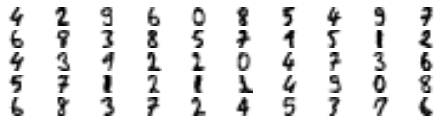

In [61]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 2))
for index, X_repres_digit in enumerate(X_repres_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_repres_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

plt.show()

In [62]:
y_repres_digits = np.array([
    4, 2, 9, 6, 0, 8, 5, 4, 9, 7,
    6, 8, 3, 8, 5, 7, 1, 5, 1, 2,
    4, 3, 9, 2, 2, 0, 4, 7, 3, 6,
    5, 7, 1, 2, 1, 1, 4, 9, 0, 8,
    6, 8, 3, 7, 2, 4, 5, 3, 7, 6])
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_repres_digits, y_repres_digits)
log_reg.score(X_test, y_test)

0.9133333333333333

In [63]:
# E se propargamos para todas as instâncias do mesmo cluster?
y_train_prop = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_prop[kmeans.labels_ == i] = y_repres_digits[i]
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train_prop)
log_reg.score(X_test, y_test)

0.9155555555555556

In [64]:
# Talvez seja melhor pegar apenas as instâncias mais próximas ao centróide
percentile_closest = 75

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_dist = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_dist)
    X_cluster_dist[in_cluster & above_cutoff] = -1
    
partially_prop = (X_cluster_dist != -1)
X_train_part_prop = X_train[partially_prop]
y_train_part_prop = y_train_prop[partially_prop]

log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train_part_prop, y_train_part_prop)

log_reg.score(X_test, y_test)

0.92

#### Comentários - Aprendizado ativo
- Poderia se fazer um aprendizado ativo, onde as instâncias nas quais o modelo ficou mais em dúvida são rotuladas por um especialista e usadas no treinamento.

## Algoritmo DBSCAN
- Dois hiperparâmetros: &epsilon; e <span style = 'font-family: Monospace;'>min_samples</span>
- Se há <span style = 'font-family: Monospace;'>min_samples</span> instâncias numa vizinhança &epsilon;, então essas instâncias serão instâncias <span style = 'font-style: italic'>core</span>
- Todas as instâncias vizinhas a instâncias <span style = 'font-style: italic'>core</span> pertencem ao mesmo cluster. As que não pertencem a cluster nenhum são anomalias
- A desvantagem é que pode ter dificuldade para capturar clusters que possuem densidades diferentes

In [21]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)
dbscan.labels_[:10] # -1 é anomalia

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5], dtype=int64)

In [22]:
print(len(dbscan.core_sample_indices_)) # número de amostras que fazem parte de um core
dbscan.components_ # instâncias core

808


array([[-0.02137124,  0.40618608],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599],
       ...,
       [ 1.66258462, -0.3079193 ],
       [-0.94355873,  0.3278936 ],
       [ 0.79419406,  0.60777171]])

In [24]:
import numpy as np
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6], dtype=int64)

In [25]:
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

DBSCAN(eps=0.2)

In [26]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

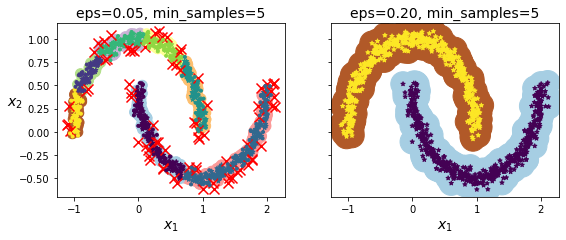

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

plt.show()

In [31]:
# DBSCAN não tem um método predict
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan2.components_, dbscan2.labels_[dbscan2.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

[1 0 1 0]


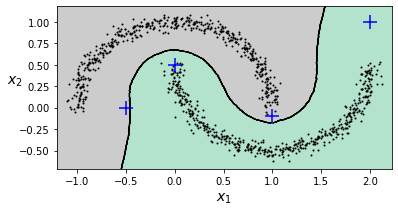

In [32]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
print(knn.predict(X_new))

plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)
plt.show()

In [38]:
# O código abaixo faz o tratamento para amostras que seriam anomalias
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan2.labels_[dbscan2.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()

array([-1,  0,  1, -1], dtype=int64)

# Mistura de Gaussianas
- Assim como no K-Means, inicializa os parâmetros aleatoriamente, atribui as instâncias a cada cluster e, feito isso, faz o ajuste das médias, covariâncias e pesos
- A diferença é que a atribuição é <span style='font-style:italic;'>soft</span> e não <span style='font-style:italic;'>hard</span>
- O hiperparâmetro <span style='font-family:monospace;'>covariance_type</span> pode ajudar a encontrar a solução para <span style='font-style:italic;'>datasets</span> mais complicados:
<ol>
    <li style='font-weight:bold;'><span style='font-family:monospace;'>spherical</span>: <span style='font-weight:normal'>todos os clusters devem ser esféricos</span></li>
    <li style='font-weight:bold;'><span style='font-family:monospace;'>diag</span>: <span style='font-weight:normal'>matriz de covariância deve ser diagonal (paralelo aos eixos)</span></li>
    <li style='font-weight:bold;'><span style='font-family:monospace;'>tied</span>: <span style='font-weight:normal'>todos os clusters têm a mesma matriz de covariância</span></li>
</ol>
<p></p>
- <span style='font-family:monospace;'>spherical</span> e <span style='font-family:monospace;'>diag</span> são O(<span style='font-style:italic'>kmn</span>) e <span style='font-family:monospace;'>tied</span> e <span style='font-family:monospace;'>full</span> são O(<span style='font-style:italic'>kmn<sup>2</sup>+kn<sup>3</sup></span>)

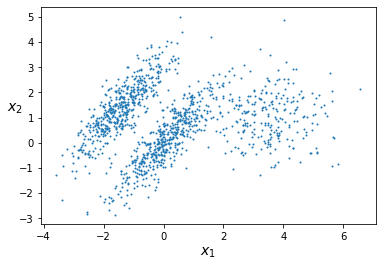

In [9]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]
plot_clusters(X)

In [11]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)
gm.weights_

array([0.39054348, 0.2093669 , 0.40008962])

In [12]:
gm.means_

array([[ 0.05224874,  0.07631976],
       [ 3.40196611,  1.05838748],
       [-1.40754214,  1.42716873]])

In [13]:
gm.covariances_

array([[[ 0.6890309 ,  0.79717058],
        [ 0.79717058,  1.21367348]],

       [[ 1.14296668, -0.03114176],
        [-0.03114176,  0.9545003 ]],

       [[ 0.63496849,  0.7298512 ],
        [ 0.7298512 ,  1.16112807]]])

In [15]:
print(gm.predict(X))
print(gm.predict_proba(X))

[0 0 2 ... 1 1 1]
[[9.77227791e-01 2.27715290e-02 6.79898914e-07]
 [9.83288385e-01 1.60345103e-02 6.77104389e-04]
 [7.51824662e-05 1.90251273e-06 9.99922915e-01]
 ...
 [4.35053542e-07 9.99999565e-01 2.17938894e-26]
 [5.27837047e-16 1.00000000e+00 1.50679490e-41]
 [2.32355608e-15 1.00000000e+00 8.21915701e-41]]


In [16]:
X_new, y_new = gm.sample(6) # É possível gerar novos dados
print(X_new, y_new)

[[-0.8690223  -0.32680051]
 [ 0.29945755  0.2841852 ]
 [ 1.85027284  2.06556913]
 [ 3.98260019  1.50041446]
 [ 3.82006355  0.53143606]
 [-1.04015332  0.7864941 ]] [0 0 1 1 1 2]


In [17]:
gm.score_samples(X) # log da PDF: quanto maior, mais denso

array([-2.60674489, -3.57074133, -3.33007348, ..., -3.51379355,
       -4.39643283, -3.8055665 ])

## Detecção de anomalia
- É útil na detecção de fraude ou na remoção de <span style='font-style:italic;'>outliers</span> antes do treinamento de um modelo

In [22]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 4)
anomalies = X[densities < density_threshold]
len(anomalies)/len(X)

0.04

## Selecionando o Número de Clusters
- Com a mistura de gaussianas, a inércia ou o coeficiente de silhouette podem não funcionar bem, pelo fato das distribuições não serem esféricas ou terem diferentes tamanhos.
- Com isso, métricas mais adequadas são os critérios teóricos de informação, como o Baysiano (BIC) e o de Akaike (AIC).
- Os dois penalizam o número de parâmetros do modelo e recompensam a verossimilhança. O BIC tende a ser mais simples e o AIC tende a generalizar melhor para <span style='font-style:italic;'>datasets</span> maiores

In [24]:
print(gm.bic(X))
print(gm.aic(X))

8189.662685850679
8102.437405735641


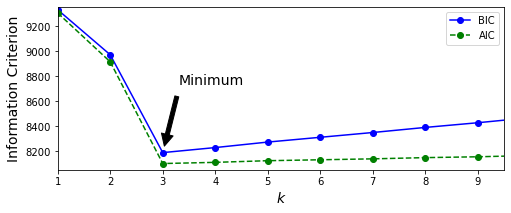

In [25]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 11)]
bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]


plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])
plt.annotate('Minimum',
             xy=(3, bics[2]),
             xytext=(0.35, 0.6),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.legend()
plt.show()

## Mistura Baysiana de Gaussianas
- Ela é capaz de fornecer pesos iguais ou próximos de zero para clusters desnecessários
- Todos os parâmetros do modelo são tratados como variáveis aleatórias latentes p(z): a partir de distribuições selecionadas se estima p(z|X).

In [26]:
from sklearn.mixture import BayesianGaussianMixture
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X)
np.round(bgm.weights_, 2)

C:\Users\Romano\anaconda3\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


array([0.4 , 0.  , 0.  , 0.  , 0.39, 0.2 , 0.  , 0.  , 0.  , 0.  ])